# Подготовка окружения

In [59]:
!pip install vk networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement networkx==2.8 (from versions: 0.34, 0.35, 0.35.1, 0.36, 0.37, 0.99, 1.0rc1, 1.0, 1.0.1, 1.1, 1.2rc1, 1.2, 1.3rc1, 1.3, 1.4rc1, 1.4, 1.5rc1, 1.5, 1.6rc1, 1.6, 1.7rc1, 1.7, 1.8rc1, 1.8, 1.8.1, 1.9rc1, 1.9, 1.9.1, 1.10rc2, 1.10, 1.11rc1, 1.11rc2, 1.11, 2.0, 2.1, 2.2rc1, 2.2, 2.3rc3, 2.3rc4, 2.3, 2.4rc1, 2.4rc2, 2.4, 2.5rc1, 2.5, 2.5.1, 2.6rc1, 2.6rc2, 2.6, 2.6.1, 2.6.2, 2.6.3)
ERROR: No matching distribution found for networkx==2.8


In [22]:
import getpass
import time
from collections import defaultdict, deque
import json

import vk
from vk.exceptions import VkAPIError

from tqdm.notebook import tqdm

import networkx as nx

import matplotlib.pyplot as plt

api = vk.API(access_token=getpass.getpass())

··········


# Извлечение данных

In [23]:
class RequestWithSleep:
    def __init__(self, max_calls_per_second=3, sleep_time=1):
        self.max_calls_per_second = max_calls_per_second
        self.sleep_time = sleep_time
        self.counter = 0
    
    def request(self, method, **kwargs):
        if self.counter % self.max_calls_per_second == 0:
            time.sleep(self.sleep_time)
        self.counter += 1
        return method(**kwargs)

requester = RequestWithSleep()

In [24]:
# 152169997

APIVersion = 5.131

visited_ids = set()
friends = defaultdict(list)

d = deque([(152169997, 0)])

num = 0

In [ ]:
while len(d) > 0:
    try:
        user_id, rank = d.popleft()
        data = requester.request(api.friends.get, user_id=user_id, v=APIVersion)
        for frnd_id in data['items']:
            if frnd_id not in visited_ids:
                friends[user_id].append(frnd_id)
                if rank < 3:
                    d.append((frnd_id, rank + 1))
    except VkAPIError as e:
        # if str(e).startswith('6.'): print(e)
        print(e)
    finally:
        visited_ids.add(user_id)
        num += 1
        if num % 1000 == 0:
            print(num)

In [26]:
with open('friends_data/friends.json', 'w') as f:
    json.dump(friends, f)

# Преобразование данных в граф

In [ ]:
with open('friends_data/friends.json') as f:
    friends = json.load(f)

In [30]:
for id in tqdm(friends):
    for id2 in friends[id]:
        if (id2 in friends) and (id not in friends[id2]):
            friends[id2].append(id)

  0%|          | 0/4819 [00:00<?, ?it/s]

In [48]:
def count_common_friends(friends, id1, id2):
    s1 = set(friends[str(id2)])
    s1.discard(id2)

    s2 = set(friends[str(id2)])
    s2.discard(id1)

    return len(s1.intersection(s2))

In [50]:
graph = nx.Graph()

visited_ids = set()

cnt = 0

for id in tqdm(friends):
    for id2 in friends[id]:
        if (str(id2) in friends) and (str(id2) not in visited_ids):
            weight = count_common_friends(friends, id, id2) / (min(len(friends[str(id)]), len(friends[str(id2)])))
            graph.add_edge(str(id), str(id2), weight=weight)
            cnt += 1
    visited_ids.add(str(id))
print(cnt)

  0%|          | 0/4819 [00:00<?, ?it/s]

51781


In [54]:
len(graph.nodes)

4819

In [73]:
nx.write_gexf(graph, "friends.gexf")

# Визуализация

В программе Gephi был использован алгоритм Лейдена для обнаружения сообществ в графе. Визуализация также выполнена там же

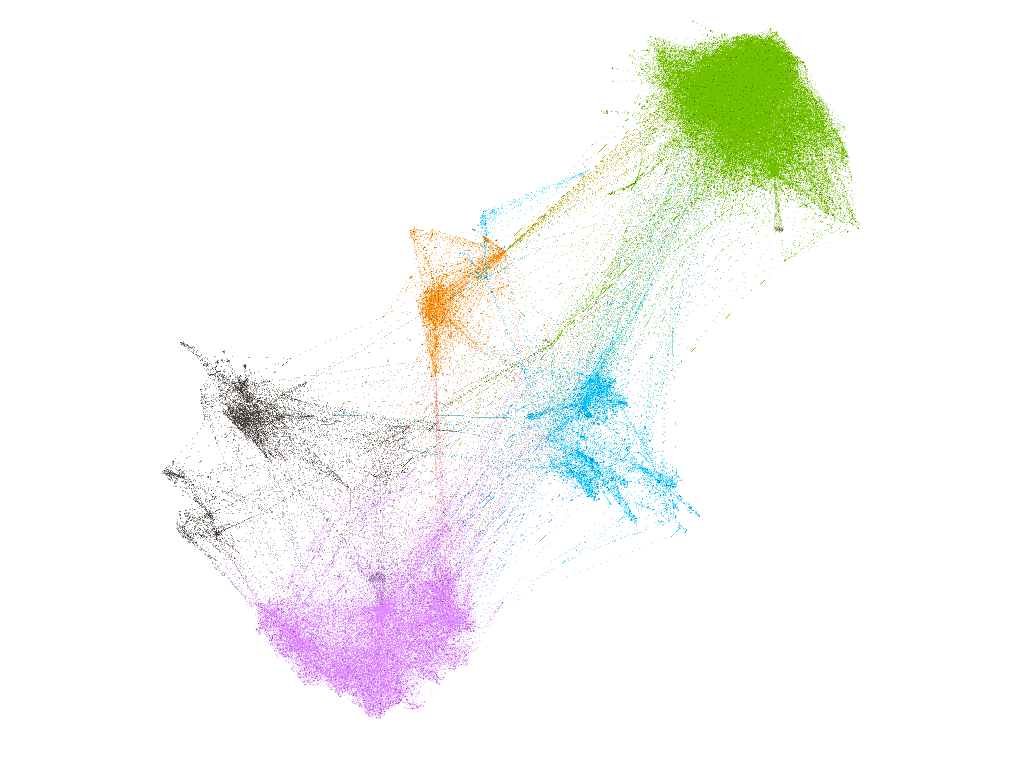